In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("ai4i2020.csv")
df["Temp_diff"]=df["Process temperature [K]"]-df["Air temperature [K]"]
df["Power"]=df["Torque [Nm]"]*df["Rotational speed [rpm]"]
features = ['Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]','Temp_diff', 'Power']
labels = ['TWF', 'HDF', 'PWF', 'OSF',
       'RNF']

X = df[features]
Y = df[labels]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
from sklearn.multioutput import ClassifierChain
from xgboost import XGBClassifier

In [5]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=6,     # handles imbalance
    n_estimators=300,
    learning_rate=0.05
)

# Classifier Chain model
chain = ClassifierChain(xgb)
chain.fit(X_train, Y_train)

# Predictions
y_pred = chain.predict(X_test)


In [7]:
import shap

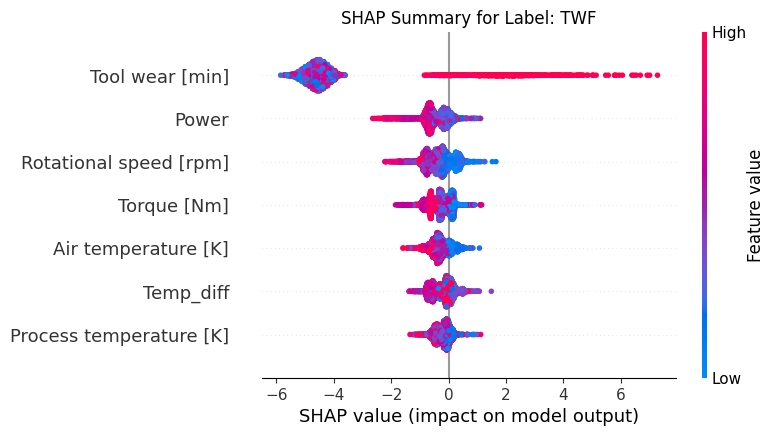

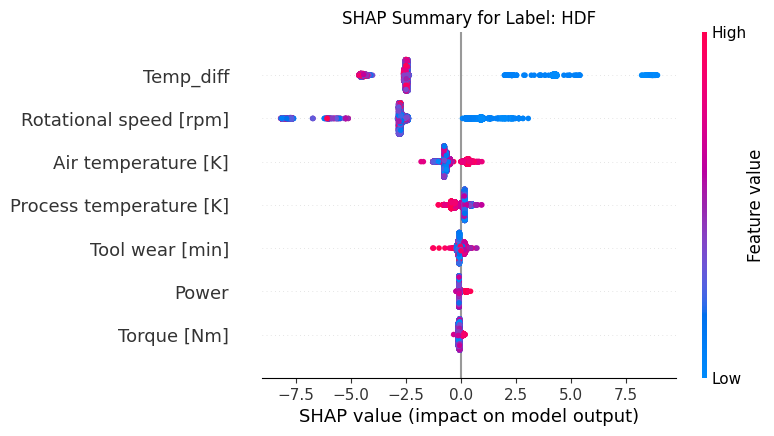

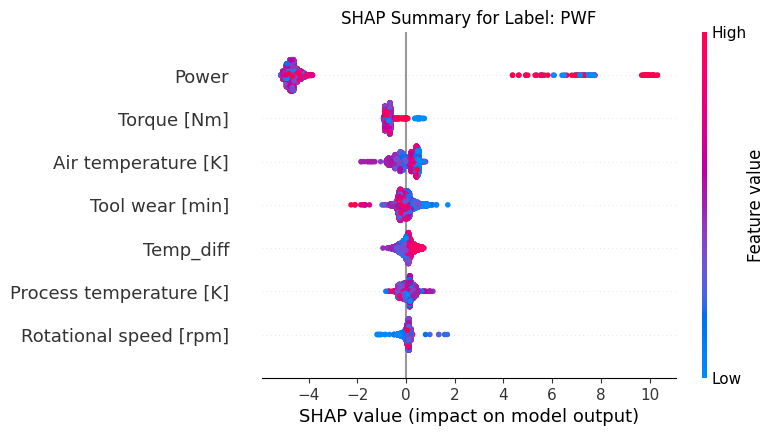

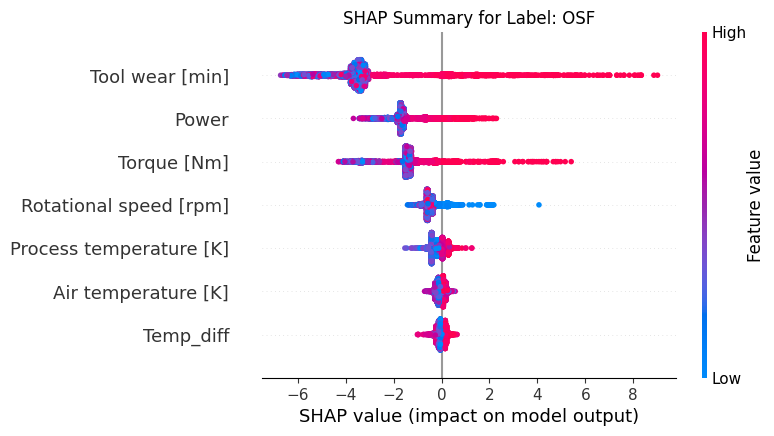

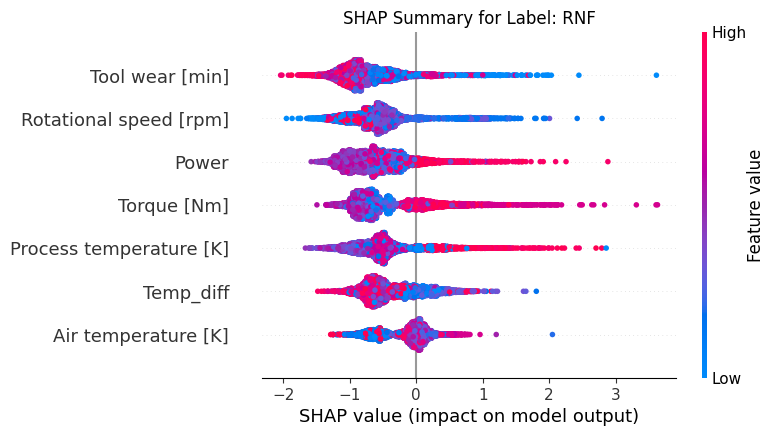

In [8]:
for i, label in enumerate(labels):
    model_i = chain.estimators_[i]

    # reconstruct the training input for ith model
    X_chain = X_train.copy()

    if i > 0:
        prev_labels = Y_train.iloc[:, :i]
        X_chain = np.hstack([X_chain, prev_labels])

    explainer = shap.TreeExplainer(model_i)
    shap_values = explainer.shap_values(X_chain)

    # Only keep SHAP values corresponding to original X features
    shap_values_filtered = shap_values[:, :len(features)]
    X_filtered = X_chain[:, :len(features)]  # decrease SHAP input too

    # Plot only real features
    shap.summary_plot(shap_values_filtered, X_filtered, feature_names=list(features),show=False )
    plt.title(f"SHAP Summary for Label: {label}")
    plt.show()

In [9]:
all_shap = []

for i, label in enumerate(labels):
    model_i = chain.estimators_[i]       # classifier for ith label

    # construct input used by the ith model
    X_chain = X_test.copy()
    if i > 0:
        prev_labels = Y_test.iloc[:, :i]
        X_chain = np.hstack([X_chain, prev_labels])

    explainer = shap.TreeExplainer(model_i)
    shap_values = explainer.shap_values(X_chain)

    # keep only original feature contributions (remove augmented label features)
    shap_values_filtered = shap_values[:, :len(features)]

    # compute mean absolute shap per feature
    mean_abs = np.mean(np.abs(shap_values_filtered), axis=0)

    df = pd.DataFrame({
        'feature': features,
        f'{label}': mean_abs
    })

    all_shap.append(df.set_index('feature'))

# combine all label SHAP importance results
overall = pd.concat(all_shap, axis=1)

# mean importance across labels
overall['mean_importance'] = overall.mean(axis=1)

# sorted final result
overall_sorted = overall.sort_values('mean_importance', ascending=False)
overall_sorted

,TWF,HDF,PWF,OSF,RNF,mean_importance
feature,,,,,,
Tool wear [min],4.336501,0.111486,0.219674,3.420731,0.778285,1.773335
Power,0.453735,0.094769,4.708615,1.546953,0.641355,1.489085
Rotational speed [rpm],0.438721,2.804336,0.104122,0.481348,0.662891,0.898284
Temp_diff,0.292343,2.890150,0.202037,0.146036,0.481345,0.802382
Torque [Nm],0.335279,0.078312,0.725243,1.527997,0.610723,0.655511
Air temperature [K],0.336831,0.643379,0.350490,0.148662,0.277889,0.351450
Process temperature [K],0.246974,0.239888,0.183813,0.225763,0.592963,0.297880


# Added Part for finding failure Cause Using Surrogate Decision Tree

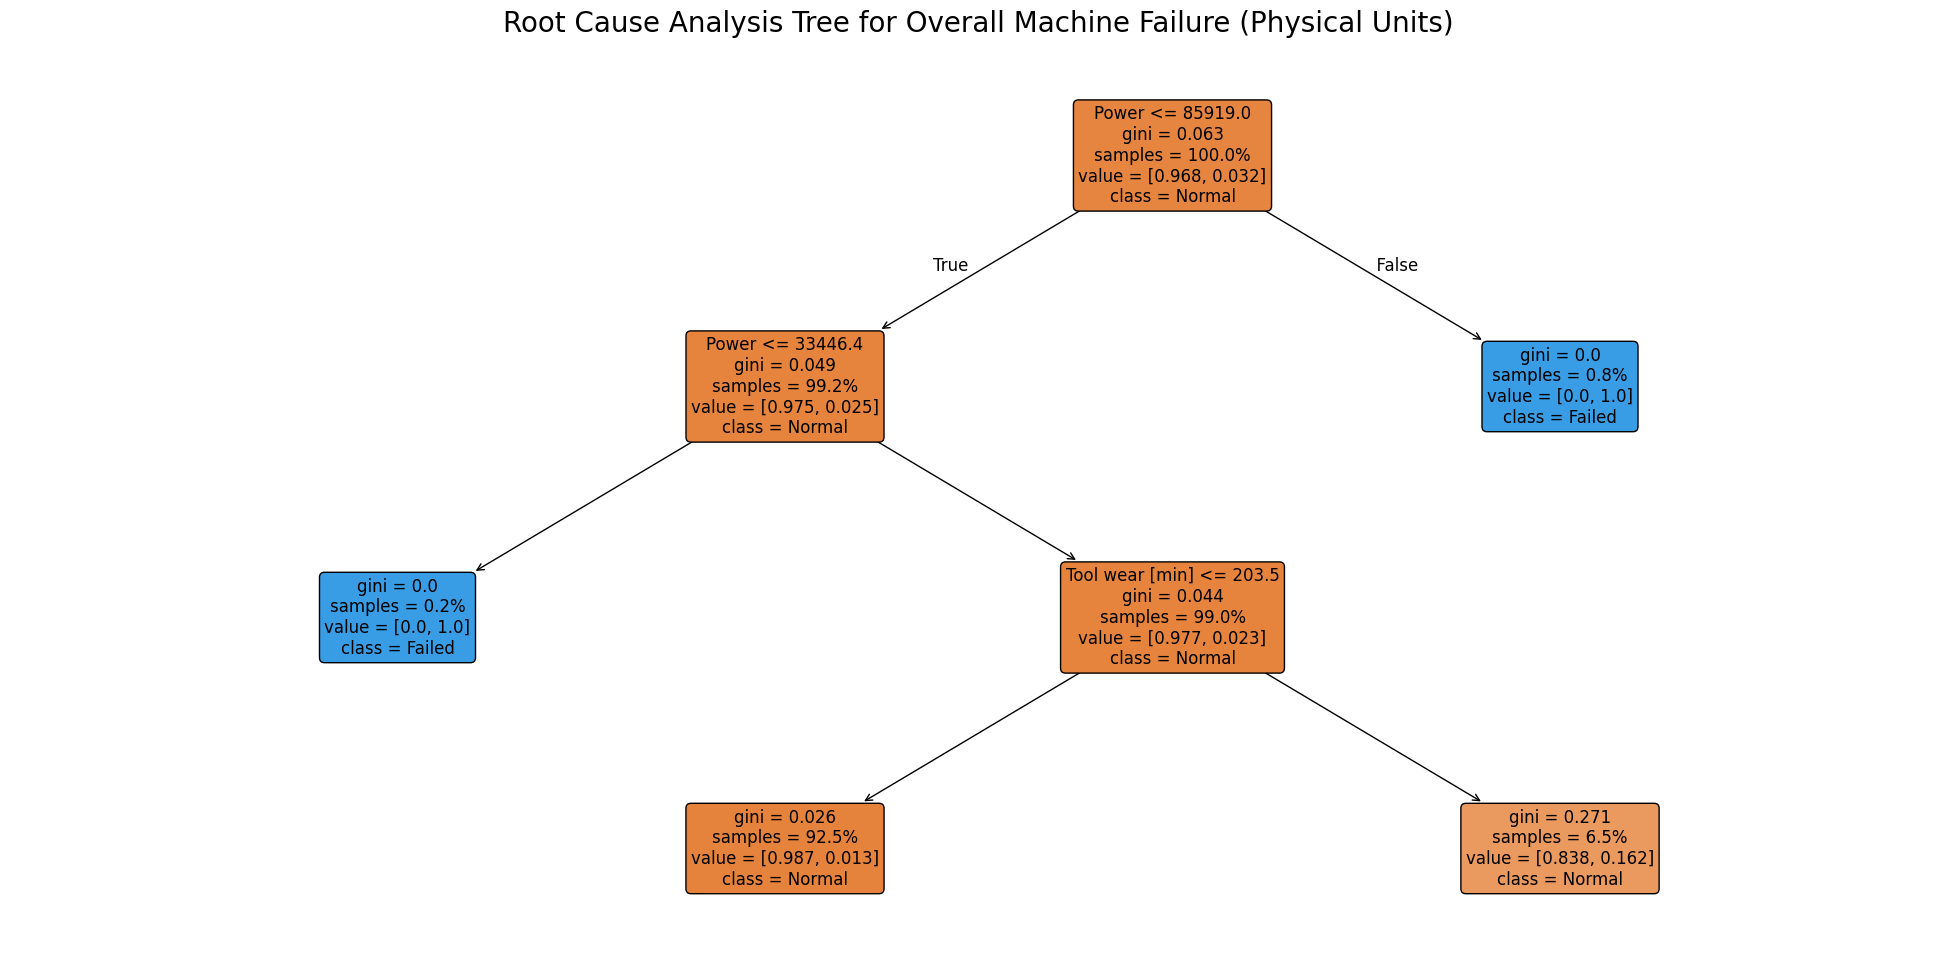

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- 1. Data Preparation ---

# Note: Assuming X_test, Y_test, scaler, and features are already defined 
# from your previous execution of the full code.

# Un-scale the test data for human-readable rules (using the correct variable: X_test)
X_test_original_array = scaler.inverse_transform(X_test) 
X_test_original = pd.DataFrame(X_test_original_array, columns=features)

# Define the overall binary target: 1 if ANY failure occurred, 0 otherwise.
Y_test_overall = Y_test.max(axis=1) 

# --- 2. Train Surrogate Root Cause Model ---
# A shallow tree (depth=3) extracts the highest-level drivers (Root Causes).
root_cause_model = DecisionTreeClassifier(max_depth=3, random_state=42)
root_cause_model.fit(X_test_original, Y_test_overall)

# --- 3. Visualize the Global Root Cause Rules ---
plt.figure(figsize=(25, 12))
plot_tree(
    root_cause_model, 
    feature_names=features, 
    class_names=['Normal', 'Failed'], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    proportion=True 
)
plt.title("Root Cause Analysis Tree for Overall Machine Failure (Physical Units)", fontsize=20)
plt.show()

In [11]:
from sklearn.tree import _tree

def extract_numerical_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    print(f"Numerical Root Cause Rules for Overall Failure:")
    print("-" * 50)

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            # Follow Left (True) branch
            print(f"{indent}IF {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            
            # Follow Right (False) branch
            print(f"{indent}ELSE (IF {name} > {threshold:.2f}):")
            recurse(tree_.children_right[node], depth + 1)
        else:
            # Reached a leaf node
            class_idx = np.argmax(tree_.value[node])
            class_name = "FAILED" if class_idx == 1 else "NORMAL"
            samples_count = tree_.n_node_samples[node]
            print(f"{indent}THEN Result = {class_name} ({samples_count} samples)")

    recurse(0, 1)

# Execute the extraction
extract_numerical_rules(root_cause_model, features)

Numerical Root Cause Rules for Overall Failure:
--------------------------------------------------
  IF Power <= 85919.00:
    IF Power <= 33446.40:
      THEN Result = FAILED (5 samples)
    ELSE (IF Power > 33446.40):
      IF Tool wear [min] <= 203.50:
        THEN Result = NORMAL (1850 samples)
      ELSE (IF Tool wear [min] > 203.50):
        THEN Result = NORMAL (130 samples)
  ELSE (IF Power > 85919.00):
    THEN Result = FAILED (15 samples)


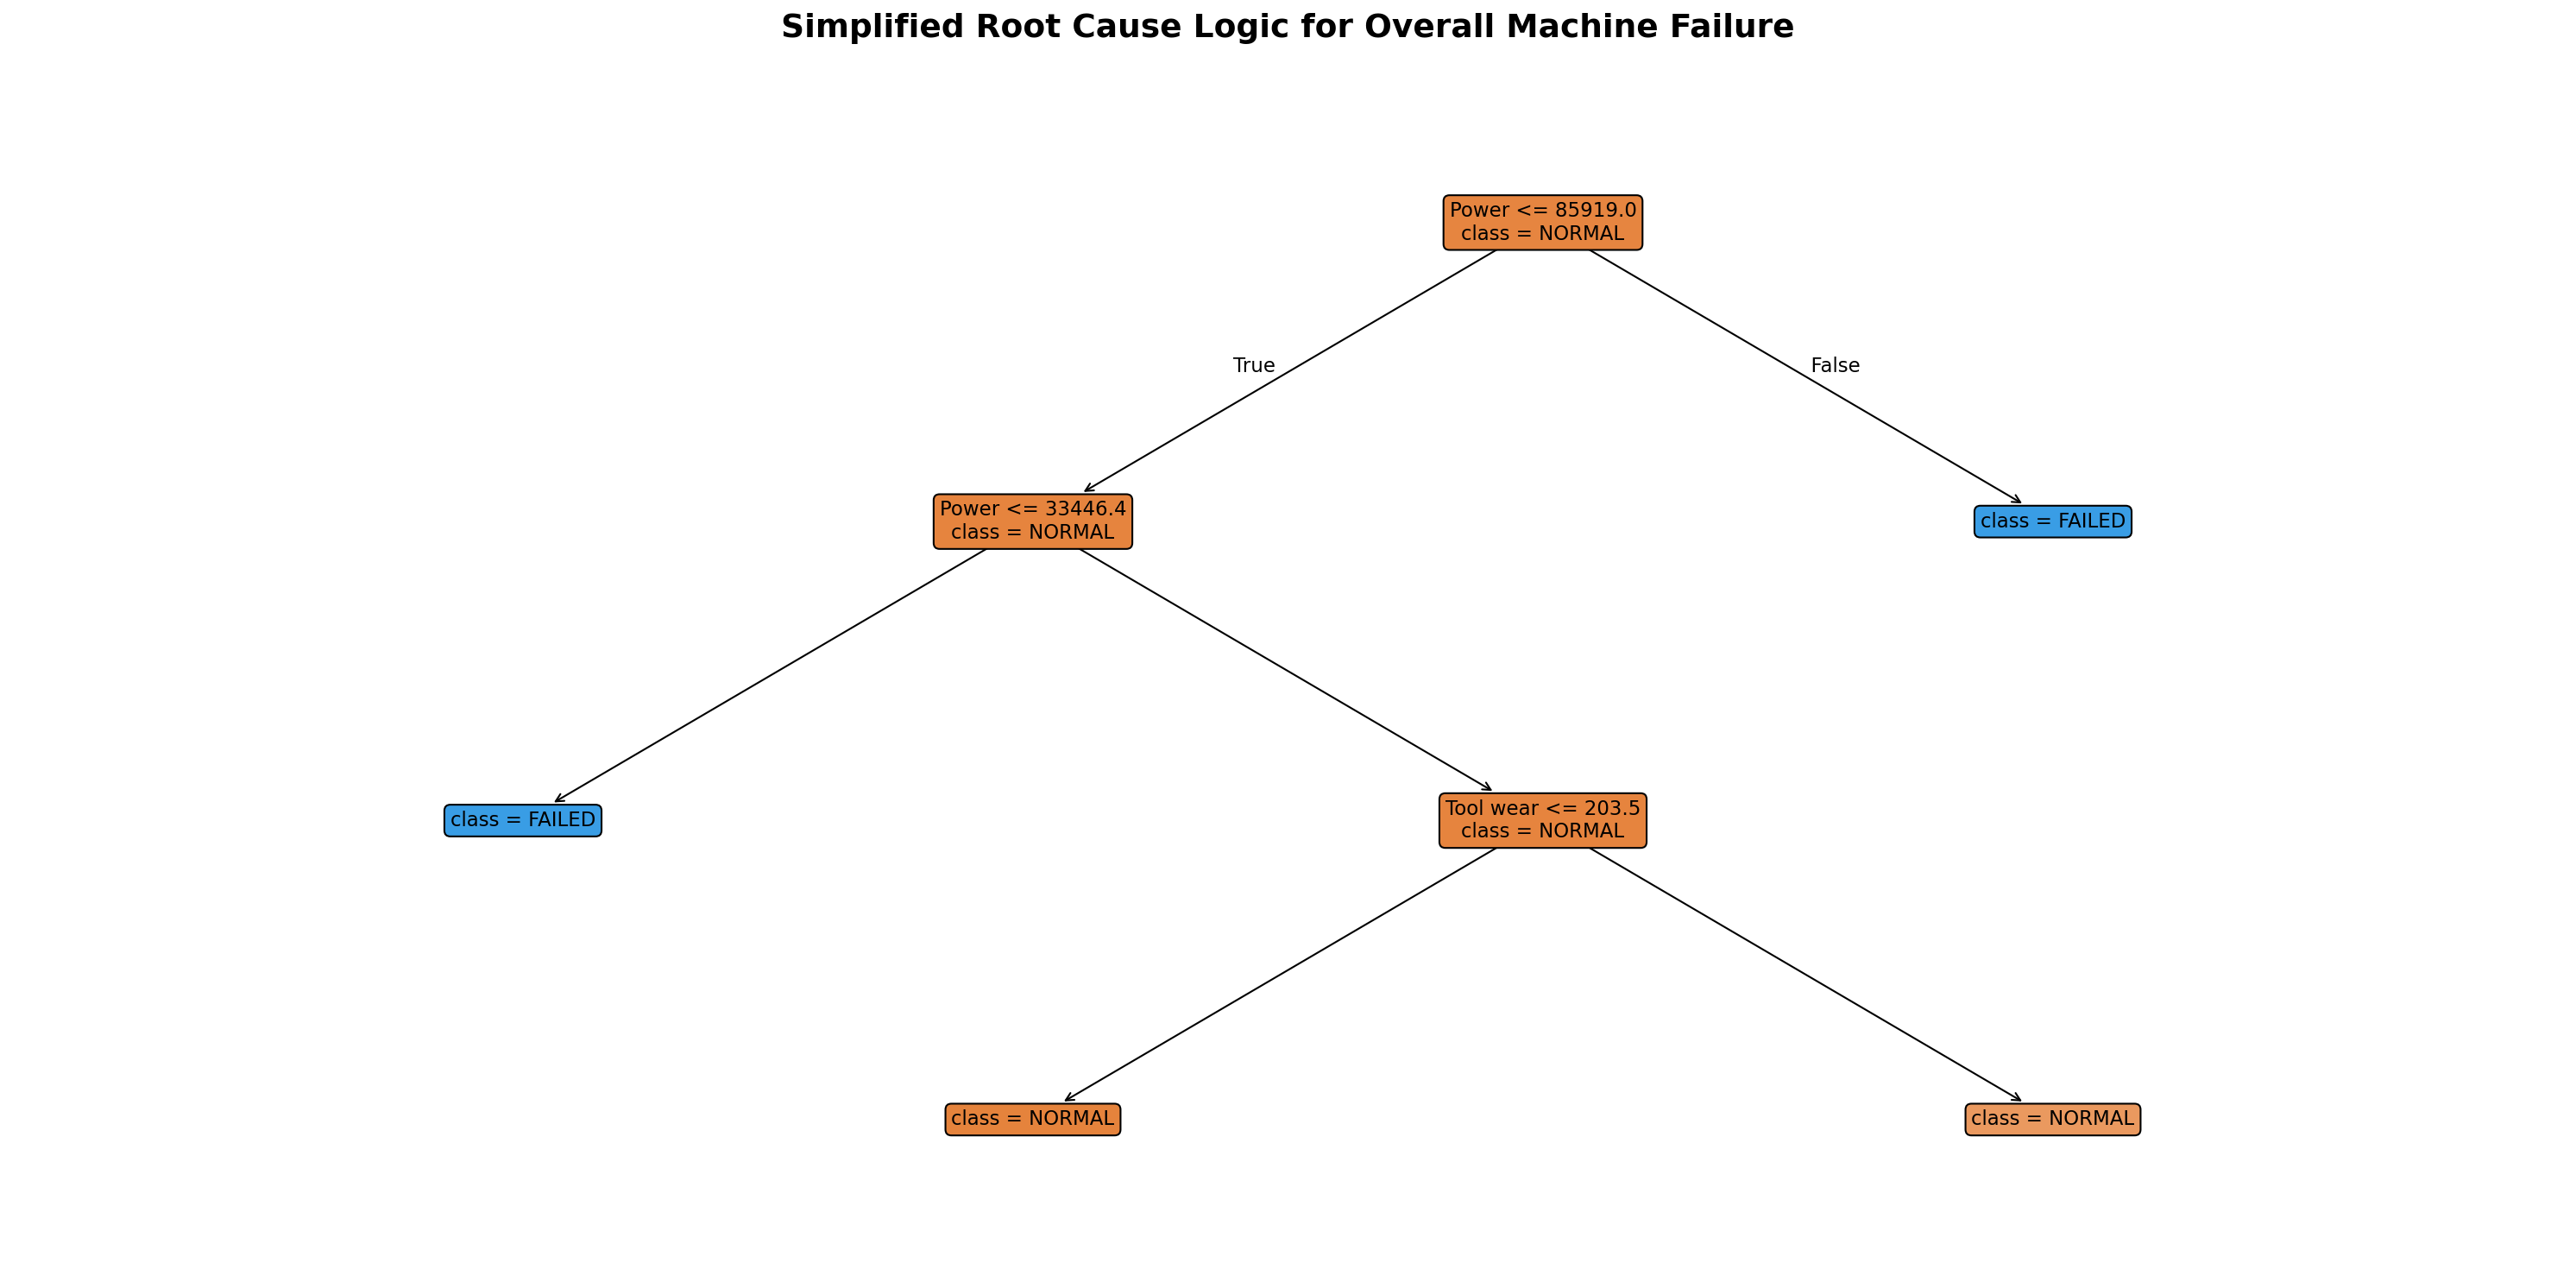

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1. Simplify feature names for cleaner labels
# This removes units like '[min]' or '[Nm]' for the display
clean_features = [f.split(' [')[0] for f in features]

# 2. Setup the figure
plt.figure(figsize=(20, 10), dpi=150) # High DPI for paper quality

# 3. Plot the styled tree
plot = plot_tree(
    root_cause_model,
    feature_names=clean_features,
    class_names=['NORMAL', 'FAILED'],
    filled=True,          # Color nodes by class
    rounded=True,         # Modern rounded corners
    fontsize=11,
    precision=1,          # Reduce decimal places for readability
    proportion=False,     # Removes percentage 
    impurity=False        # REMOVES 'Gini' to keep it clean
)

# 4. Post-processing: Manually remove "samples" and "value" text for a "clean" look
# This keeps only the Feature Condition and the Class Name
for txt in plot:
    text = txt.get_text()
    # Filter out lines we don't want
    lines = [line for line in text.split('\n') if "samples" not in line and "value" not in line]
    txt.set_text("\n".join(lines))

plt.title("Simplified Root Cause Logic for Overall Machine Failure", fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Conclusion

1. SHAP Summary Plot (TWF)   ->      Predictive Importance (Correlation)        ->         Tool wear [min] is the most important predictor or mechanism for failure.

2. Surrogate Decision Tree (Overall Failure)   ->   Global Root Cause Rules (Causation/Thresholds)       ->       Power is the most critical global root cause threshold, independent of wear, as $\text{Power} > 85919.0$ leads directly to failure.

While the model relies most heavily on Tool wear [min] to make its prediction, the analysis proves that the Power threshold is the most immediate root cause trigger of overall machine failure.